# **Deep Learning Project** 

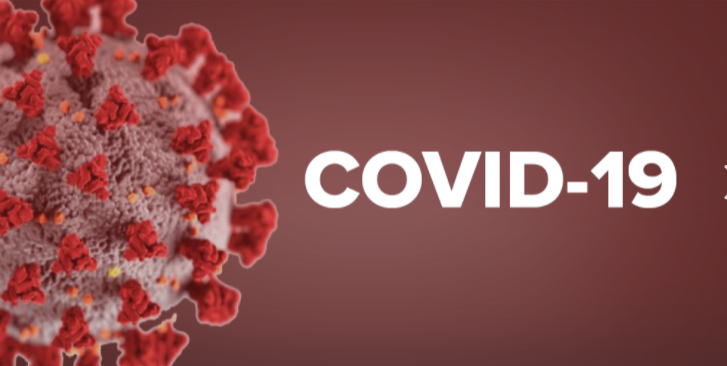

*By 
Ahmed El Melegy
,Ahmed Eid 
,Khalid Alab*d

#### Reading the dataset and import used libraries

Note : Follow the printed link to permit colab use the dataset on google drive, and enter the link that google will give it to you access the dataset 

In [ ]:
import os
import numpy as np
import pandas as pd
from keras.preprocessing.image import ImageDataGenerator, load_img

# Import PyDrive and associated libraries.
# This only needs to be done once per notebook.
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

# Authenticate and create the PyDrive client.
# This only needs to be done once per notebook.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

# Download a file based on its file ID.
#
# A file ID looks like: laggVyWshwcyP6kEI-y_W3P8D26sz
file_id = '11e-fAH7Uvhy5_yvZDRxHs4RBx3Zh3itQ'
downloaded = drive.CreateFile({'id': file_id})
downloaded.GetContentFile('Covid19-dataset-dl.zip')

Unzip the dataset

In [ ]:
!mkdir /content/Covid19-dataset-dl
!unzip -q /content/Covid19-dataset-dl.zip -d /content/Covid19-dataset-dl

mkdir: cannot create directory ‘/content/Covid19-dataset-dl’: File exists
unzip:  cannot find or open /content/Covid19-dataset-dl.zip, /content/Covid19-dataset-dl.zip.zip or /content/Covid19-dataset-dl.zip.ZIP.


Define the train, test and validation directories to the dataset

In [ ]:
train_data_dir = r"/content/Covid19-dataset-dl/Covid19-dataset-dl/train"
test_data_dir = r"/content/Covid19-dataset-dl/Covid19-dataset-dl/test"
vald_data_dir = r"/content/Covid19-dataset-dl/Covid19-dataset-dl/vald"


# **Build The image generator** 

In [ ]:
train_datagen = ImageDataGenerator (
    
    rotation_range = 15,
    rescale = 1./255,
    
    shear_range = 0.1,
    zoom_range = 0.2,
    
    horizontal_flip = True,
    width_shift_range = 0.1,
    height_shift_range = 0.1
)
test_datagen=ImageDataGenerator(rescale=1./255)
valid_datagen = ImageDataGenerator(rescale=1./255)

## Read the image genertor with specific batch and image size 

In [ ]:
img_width, img_height = 150, 150
batch_size = 8

train_generator = train_datagen.flow_from_directory(train_data_dir, target_size=(img_height, img_width), batch_size=batch_size, class_mode='categorical')
test_generator = test_datagen.flow_from_directory(test_data_dir, target_size=(img_height, img_width), batch_size=batch_size, class_mode='categorical')
vald_generator = valid_datagen.flow_from_directory(vald_data_dir, target_size=(img_height, img_width), batch_size=batch_size, class_mode='categorical')


Found 1769 images belonging to 3 classes.
Found 957 images belonging to 3 classes.
Found 1081 images belonging to 3 classes.


# **Build The model Architecture** 

Fine tuning and early stopping 

In [ ]:
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
earlystop = EarlyStopping(monitor='accuracy',patience=3)

learning_rate_reduction = ReduceLROnPlateau(monitor = 'loss', 
                                            patience = 2, 
                                            verbose = 1, 
                                            factor = 0.5, 
                                            min_lr = 0.00001)

callbacks = [earlystop, learning_rate_reduction]

build the layers 

In [ ]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense, Activation, BatchNormalization
'''
#This the model used first and it was inefficient with the previous defined callbacks 
# please refer to the project report for more detailed explanation and the source of the model. 
model = Sequential()

model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(img_width, img_height, 3)))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(32, (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(3, activation='softmax', name='predictions')) 

model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

model.summary()
'''
# this the second model we used we build this model by our hands by the helping of trail 
# error and observing how the model evualaton behave with adding or removing each layer  
# this model is simpler than the previous used won however it proven that this model 
# result in more efficient in accuracy and loss and more stable than the first model 

import tensorflow as tf
 
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(16, (3,3),activation='relu', input_shape=(img_width, img_height, 3)),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(32, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2), 
    tf.keras.layers.Conv2D(64, (3,3),activation='relu'), 
    tf.keras.layers.MaxPooling2D(2,2),
    # Flatten the results to feed into a DNN
    tf.keras.layers.Flatten(), 
    # 512 neuron hidden layer
    tf.keras.layers.Dense(512, activation='relu'), 
    tf.keras.layers.Dense(3, activation='softmax')  
])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 148, 148, 16)      448       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 74, 74, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 72, 72, 32)        4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 36, 36, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 34, 34, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 17, 17, 64)        0         
_________________________________________________________________
flatten (Flatten)            (None, 18496)             0

adam proven that is best optimizer to be used than sgd or any other optmization technqiue used.

In [ ]:
model.compile(optimizer='adam', loss= 'categorical_crossentropy', metrics=['accuracy'])

# **Model Result** 

In [ ]:
history = model.fit_generator(train_generator,
                              validation_data=vald_generator,
                              epochs=25,
                              verbose=1)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1940: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/25
222/222 [==============================] - 34s 123ms/step - loss: 0.8000 - accuracy: 0.6631 - val_loss: 1.4455 - val_accuracy: 0.4329
Epoch 2/25
222/222 [==============================] - 27s 124ms/step - loss: 0.5251 - accuracy: 0.7942 - val_loss: 0.9493 - val_accuracy: 0.5800
Epoch 3/25
222/222 [==============================] - 27s 123ms/step - loss: 0.4726 - accuracy: 0.8146 - val_loss: 1.1802 - val_accuracy: 0.5393
Epoch 4/25
222/222 [==============================] - 27s 122ms/step - loss: 0.4294 - accuracy: 0.8412 - val_loss: 0.9600 - val_accuracy: 0.5708
Epoch 5/25
222/222 [==============================] - 27s 124ms/step - loss: 0.4049 - accuracy: 0.8462 - val_loss: 1.1950 - val_accuracy: 0.5134
Epoch 6/25
222/222 [==============================] - 27s 123ms/step - loss: 0.4113 - accuracy: 0.8479 - val_loss: 0.8818 - val_accuracy: 0.5698
Epoch 7/25
222/222 [==============================] - 27s 123ms/step - loss: 0.3365 - accuracy: 0.8847 - val_loss: 0.7881 - val_ac

In [ ]:
model.evaluate(test_generator)

120/120 [==============================] - 4s 35ms/step - loss: 0.1501 - accuracy: 0.9509


[0.15011855959892273, 0.9508882164955139]

Train accuracy is 92 , and test accuracy is 95  more efficient and stable than the first model (the one introduced in the demo ) 

### save the model weights

In [ ]:
model.save_weights("COVID-Model.h5")

# **visualization**

## Plot the train curve and test curve 

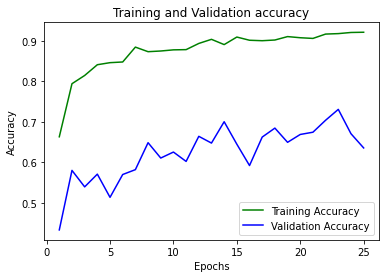

In [ ]:
import matplotlib.pyplot as plt
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']
numEpochs = range(1,  25 + 1)
plt.plot(numEpochs, accuracy, 'g', label='Training Accuracy')
plt.plot(numEpochs, val_accuracy, 'b', label='Validation Accuracy')
plt.title('Training and Validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

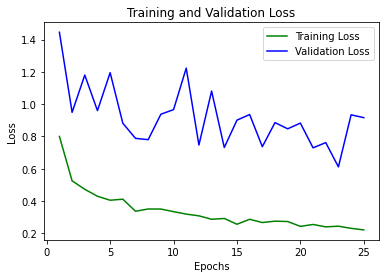

In [ ]:
loss = history.history['loss']
val_loss = history.history['val_loss']
numEpochs = range(1,  25 + 1)
plt.plot(numEpochs, loss, 'g', label='Training Loss')
plt.plot(numEpochs, val_loss, 'b', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

#T**hird Model -CovidNet**

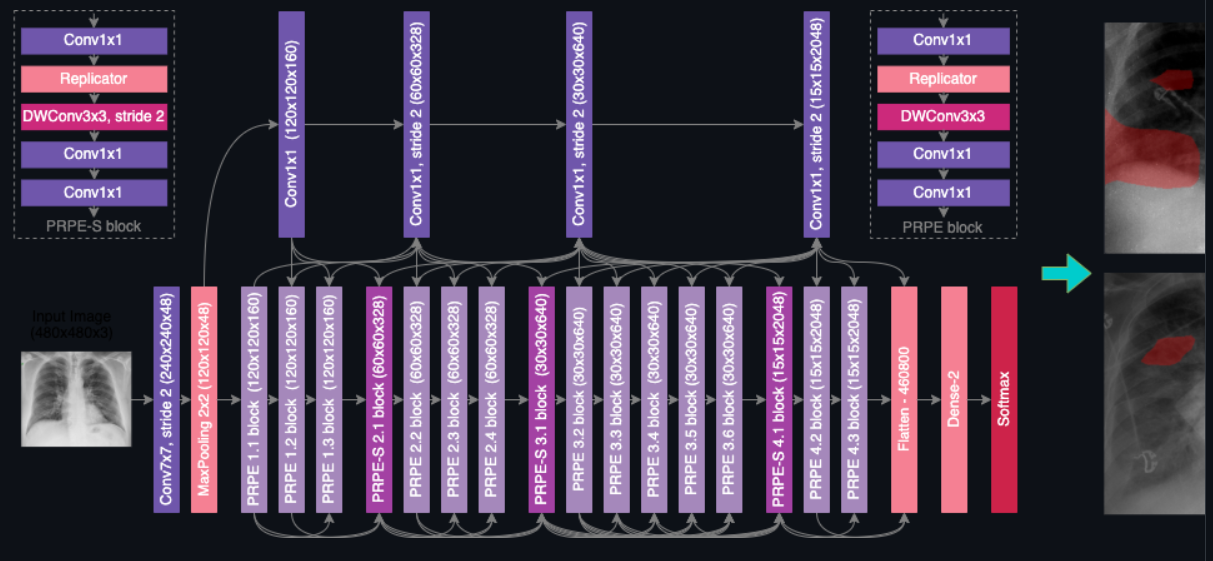

## CovidNet model -CXR this model was proposed to be used by Dr.Mohamed 

### link to the model 
https://github.com/aalhaimi/covid-net-cxr-shuffle

Model library pytorch not keras 

Source Code is : https://github.com/aalhaimi/covid-net-cxr-shuffle 

THis IS ONE MODEL THAT IS USED IN THE MODEL CXR , 

PLEASE REFERENCE FOR THE PROJECT REPORT  FOR MORE 

DETAILS ABOUT THE MODEL USED 

the following cell for training preprocessing 
such as reading the dataset , croping and augmentation

In [ ]:
import numpy as np
import torch
import torchvision
import imgaug as ia
from PIL import Image
from imgaug import augmenters as iaa

np.random.seed(42)
torch.manual_seed(42)
ia.seed(42)

# preprocessing techniques
class RemoveScanInfo(object):
    def __call__(self, img):
        w,h = img.size
        img = torchvision.transforms.functional.crop(img, int(h/6), 0, h-int(h/6) , w )
        return img

class HistogramNorm(object):
    def __init__(self):
        self.hnorm = iaa.HistogramEqualization()
    def __call__(self, img):
        img = np.array(img)
        img = self.hnorm.augment_image(img)
        img = Image.fromarray(img)
        return img


def load_alldataset(dataset):
    data_loader = torch.utils.data.DataLoader(dataset, batch_size=len(dataset))
    data = {}
    for i_batch, sample_batched in enumerate(data_loader):
        data = sample_batched
    return data

## MODEL TRAINING

In [ ]:
# ---------------- COVIDNet-CXR-Shuffle -------------------- # 
import torch
import torchvision
import numpy as np 
#import utils 
import torch.utils.data

torch.manual_seed(42)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'[INFO] Using {device} to train the model')


# ----------  INPUTS ----------
model_path = '/content/covidnet-cxr-shuffle-e18.pth' 
data_path = '/content/Covid19-dataset-dl/Covid19-dataset-dl/train'
valid_path = '/content/Covid19-dataset-dl/Covid19-dataset-dl/vald'

epochs = 20
batch_size = 32

# inits
train_losses = []
val_losses = []
val_accs = []
cur_epoch = 0
best_acc = 0


# ---------- DATA LOADING AND AUGMENTATIONS ----------
trn_trans = torchvision.transforms.Compose([
    RemoveScanInfo(),
    torchvision.transforms.Resize((224,224)),
    HistogramNorm(),
    torchvision.transforms.RandomOrder([
        torchvision.transforms.RandomAffine(degrees=(-45,45), translate=(0.1,0.1), scale=(0.9,1.1)),
        torchvision.transforms.RandomHorizontalFlip(p=0.5),
        torchvision.transforms.RandomVerticalFlip(p=0.5),
        ]),
    torchvision.transforms.ToTensor(),
    torchvision.transforms.RandomErasing(p=0.2, scale=(0.003, 0.03))
    ])

val_trans = torchvision.transforms.Compose([
        RemoveScanInfo(),
        torchvision.transforms.Resize((224,224)),
        HistogramNorm(),
        torchvision.transforms.ToTensor(),
    ])

train_set = torchvision.datasets.ImageFolder(data_path , transform = trn_trans)
val_set = torchvision.datasets.ImageFolder(valid_path , transform = val_trans)
train_loader = torch.utils.data.DataLoader(dataset=train_set, batch_size=batch_size, shuffle=True)
val_loader = torch.utils.data.DataLoader(dataset=val_set, batch_size=batch_size, shuffle=True)


# ---------- DL MODEL ARCH ----------
model = torchvision.models.shufflenet_v2_x1_0(pretrained=True)
model.fc = torch.nn.Linear(1024, 3) 

optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
adjustLR = torch.optim.lr_scheduler.CyclicLR(optimizer, base_lr=1e-5, max_lr=1e-3, mode='exp_range', cycle_momentum=False)
ce_loss = torch.nn.CrossEntropyLoss()

# --- RESTORE CHECKPOINTS ----
# checkpoint = torch.load(model_path)
# model.load_state_dict(checkpoint['model_state_dict'])
# cur_epoch = checkpoint['epochs'] - 1
# best_acc = checkpoint['best_acc']


# --- TRAIN FOR-LOOP ----
for e in range(epochs):
    e += cur_epoch + 1
    running_loss = 0 
    for i, (inputs, targets) in enumerate(train_loader):
        model = model.to(device)
        model = model.train() 
        x = inputs.to(device)   
        y = targets.to(device)   
        optimizer.zero_grad()
        outputs = model(x)
        loss = ce_loss(outputs, y)
        loss.backward()
        optimizer.step()
        adjustLR.step()
        running_loss += loss.item()
    else:
        val_loss = 0
        val_acc = 0
        batch_correct = 0
        batch_total = 0
        with torch.no_grad():
            model = model.eval()
            for i, (inputs, targets) in enumerate(val_loader):
                x = inputs.to(device)      
                y = targets.to(device)   
                outputs = model(x)
                loss = ce_loss(outputs, y)
                val_loss += loss.item()
                batch_total += y.size(0)
                _, predicted = torch.max(outputs.data, 1)
                batch_correct += (predicted == y).sum().item()
                val_acc = batch_correct / batch_total
        val_accs.append( val_acc )
        val_losses.append(val_loss / len(val_loader))
        train_losses.append(running_loss / len(train_loader) )

        if val_accs[-1] >= best_acc:
            best_acc = val_accs[-1]
            torch.save({
                    'model': model.train(),
                    'epochs': e,
                    'model_state_dict': model.state_dict(),
                    'optimizer_state_dict': optimizer.state_dict(),
                    'best_acc': best_acc}, model_path)

        print ('Epochs: {}/{} '.format(e, epochs),
                'Train Loss: {:.7f} '.format(train_losses[-1]),
                'Val Loss: {:.7f} '.format(val_losses[-1]),
                'Val Acc: {:.7f}'.format(val_accs[-1]),
                'Best Val Acc: {:.7f}'.format(best_acc))

[INFO] Using cuda to train the model
Epochs: 1/20  Train Loss: 1.0938933  Val Loss: 1.0958495  Val Acc: 0.3617021 Best Val Acc: 0.3617021
Epochs: 2/20  Train Loss: 1.0656195  Val Loss: 1.0719050  Val Acc: 0.4542091 Best Val Acc: 0.4542091
Epochs: 3/20  Train Loss: 0.9337825  Val Loss: 0.9873690  Val Acc: 0.5171138 Best Val Acc: 0.5171138
Epochs: 4/20  Train Loss: 0.6104203  Val Loss: 0.8366326  Val Acc: 0.5948196 Best Val Acc: 0.5948196
Epochs: 5/20  Train Loss: 0.3881033  Val Loss: 0.8154734  Val Acc: 0.5957447 Best Val Acc: 0.5957447
Epochs: 6/20  Train Loss: 0.3300130  Val Loss: 0.8433741  Val Acc: 0.5679926 Best Val Acc: 0.5957447
Epochs: 7/20  Train Loss: 0.2784278  Val Loss: 0.7054558  Val Acc: 0.6364477 Best Val Acc: 0.6364477
Epochs: 8/20  Train Loss: 0.2468993  Val Loss: 0.6575278  Val Acc: 0.6308973 Best Val Acc: 0.6364477
Epochs: 9/20  Train Loss: 0.2376131  Val Loss: 0.7930973  Val Acc: 0.6197965 Best Val Acc: 0.6364477
Epochs: 10/20  Train Loss: 0.2108714  Val Loss: 0.5158

##Test the model

In [ ]:
# ---------------- COVIDNet-CXR-Shuffle  -------------------- # 
import time
import torch
import torchvision
import numpy as np  
import torch.utils.data
from sklearn.metrics import confusion_matrix, accuracy_score

torch.manual_seed(42)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'[INFO] Using {device} for prediction')


# ----------  INPUTS ----------
model_path = '/content/covidnet-cxr-shuffle-e18.pth' 
data_path_tst = '/content/Covid19-dataset/Covid19-dataset/test'


# ---------- DATA LOADING ----------
trans = torchvision.transforms.Compose([
        RemoveScanInfo(),
        torchvision.transforms.Resize((224,224)),
        HistogramNorm(),
        torchvision.transforms.ToTensor(),
    ])

tst_set = torchvision.datasets.ImageFolder(data_path_tst, transform = trans)
tst = load_alldataset(tst_set)
tst[1][:].shape
x = tst[0][:]
y = tst[1][:]
subtitle = 'COVIDx2 (tst)'


# ---------- DL MODEL ARCH ----------
model = torchvision.models.shufflenet_v2_x1_0().float().to(device)
model.fc = torch.nn.Linear(1024, 3) 


## --- RESTORE CHECKPOINTS ----
checkpoint = torch.load(model_path, map_location=device)
model.load_state_dict(checkpoint['model_state_dict'])


# ---------- PREDICTIONS ----------
def predict(x, y):
    model.eval().to(device)
    correct = 0
    total = 0
    with torch.no_grad():
        pred = model(x)
        label = y.to(device)
        pred = pred.to(device)
        return (label, pred)
 
start = time.time()
val_label, val_pred = predict(x.to(device), y.to(device))
val_label, val_pred = val_label.cpu(), val_pred.cpu()
val_pred = [ np.argmax(t) for t in val_pred ]


## ---------- CONFUSION MATRIX ----------
cm = confusion_matrix(val_label, val_pred)
acc = accuracy_score(val_label, val_pred)
print(f'[INFO] Confusion Matrix of {subtitle}')
print('class 0: COVID-19, class 1: normal, class 2: pneumonia')
print(cm)
print(f'Overall Accuracy: {round(acc * 100, 3)}%')

print(f'[INFO] Predicted {x.shape[0]} images in {round(time.time() - start, 4)} seconds on {device}')
print(f'[INFO] Prediction is complete.')

[INFO] Using cuda for prediction
[INFO] Confusion Matrix of COVIDx2 (tst)
class 0: COVID-19, class 1: normal, class 2: pneumonia
[[310  12   1]
 [  0 295  22]
 [  1  10 306]]
Overall Accuracy: 95.193%
[INFO] Predicted 957 images in 1.1482 seconds on cuda
[INFO] Prediction is complete.


training loss is 0.15 which is better than our model 0.22 and model test accuracy is 95.1 large little bit than our model 95.0 in overall the model behave more effecient than our model  